# Часть 1

## Какая задача решалась

В ходе тестового задания я решал задачу one-shot Voice Conversion. Суть её состоит в том, чтобы построить модель, способную перенести стиль аудиофайла на другой при этом сохранить исходный контекст, используя минимальное количество аудиодорожек

## В чём основная идея метода и в чём её отличие от других решений?

На данный момент уже разработаны различные подходы, например: генеративные сети, вариативные автоэнкодеры. Но данные подходы не могут обеспечить принцип ONE-SHOT, когда нейросеть не использует исходный и целевой голос в процессе обучения. Наиболее близкая модель, удовлетворяющая этому требованию состоит из двух независимых декодеров, получающих информацию о контексте и стиле независимо. Данный подход имеет следующие минусы: увеличивает количество обучаемых параметров что замедляет процесс обучения и инференса, а также имеет сомнительную нужность. В данной статье отказались от второго декодера мотивируя это тем, что информация о целевом стиле является временно-независимой и может быть восстановленна с помощью среднего и стандартного отклонения всей аудио-дорожки. Данная идея реализована следующим образом. В блоках енкодера с помощью слоев instance-normalization (IN) мы затираем информацию о стиле, но не трогаем контекст. В блоках декодера используя слои ADAPTIVE INSTANCE NORMALIZATION (AdaIN) восстанавливаем стиль с помошью средних и стандартного отклонения из слоёв IN енкодера. Ещё одним новшеством является слой ACTIVATION GUIDANCE, необходимый для того, чтобы по скрытому состоянию контекста нельзя было классифицировать говорящего, тем самым полностью избавиться от индивидуальности (читай от стиля говорящего). Авторами были использованы различные функции активации, оставновились на сигмоиде с параметром alpha = 0.1


## Какой эксперимент ставился? Какие получились результаты и как их можно интерпретировать?

В ходе эксперимента я обучил нейросеть 20 эпохах восстанавливать исходную мел-спектрограмму. Это является основным критерием, влияющим на результат переноса стиля. Средний лосс L1 на трейн/тест достиг результата 0.2209/0.2256 что как минимум значит что модель спасобна восстанавливать свою мелспектрограмму после уменьшения её размерности с (80,-1) до (4,-1) + нарушения вектора контекста сигмоидой с параметром alpha=0.1. В файле DEMO.ipynb можно запустить аудиодорожки до/после работы модели. Стоит отметить что модель отдает мел-спектрограмму. Для преобразования её в wav файл используется предобученный вокодер MelGan, в ходе эксперементов оказалось, что он не справляется со своей работой (и/или ошибки в предобработке звуковых дорожек)

### Данные для обучения

В качестве данных для обучения был выбран датасет VCTK. 80 спикеров с 200 фразами у каждого отобрал для трейна, 29 спикеров с 200 фразми у каждого для теста.

### Параметры

Модель имеет 6 блоков со свертками 3 на 3 и количеством фильтров 256. alpha = 0.1

Оптимизатор ADAM: Lr=0.0005, β1 = 0.9, β2 = 0.999

20 Эпох для обучения

## Как можно использовать полученный результат? Удалось ли приблизиться к цифрам из статьи? Какие есть перспективы для развития?

Обучение модели занимает значительное время. В статье обучали 100к итераций, модель в репозитории сделала только 10к шагов, но уже на пол пути к результатам из статьи. По графикам видно, что модель не переобучается, процесс обучения стоит продолжить, добавив LR SCHEDULER. Средние значения и стандартное отклонение используется только в слоях AdaIN, возможно стоит добавить механизмы атеншена в декодере и прикрутить их к рекуррентному слою в качестве скрытых состояний. Плюс если фиксануть проблему с вокодером то уже будут вполне неплохие результаты

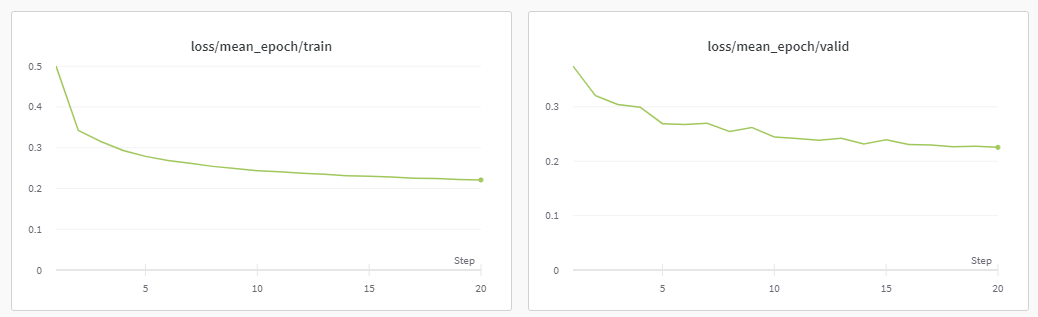

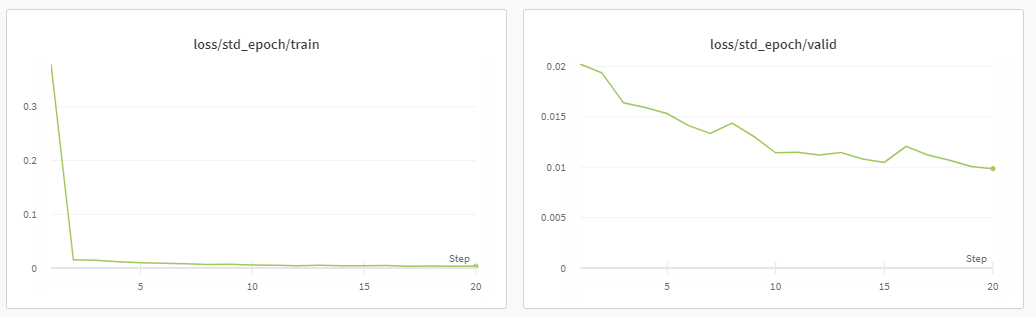

# Часть 2

https://www.unofficialgoogledatascience.com/2021/04/why-model-calibration-matters-and-how.html

Это статья о калибровках моделей машинного обучения. Дело в том что сейчас я очень часто имею дело с табличными данными и занимаюсь многоуровневыми моделями. В таких случаях калибровка моделей является не последним делом. Данная статья мне не особо помогла в работе (там нужны другие калибровки по срезам пользователей) но наметила острые углы. 